# W207 Final Project: Final Model - TalkingData AdTracking Fraud Detection

**Team:** Samantha Williams, Vincent Goldberg and Heaven Klair


## **Introduction & Recap:** 
The [Kaggle competition](https://www.kaggle.com/competitions/talkingdata-adtracking-fraud-detection/overview) we have chosen was designed to find an algorithm for TalkingData that would best predict an app download after a mobile advertisement click is made. The problem that we are asked to solve is a predictive one: *After clicking the ad, will the user download the app?* 
 
You can find more of our work on this challenge by reviewing out baseline notebook [here](https://colab.research.google.com/drive/1EhCVK4EQCSxp0PDmFO5Hrh3AH36DxPNB#scrollTo=kQphqHuuoudm).
 
Going forward this notebook will explore the feature engineering we conducted along with the models that we explored while working on this project. It wasn't easy and we found at times that we did not have enough RAM to really let some of our larger models run. After some additional research we found a model that would work beautifully with our data. Enjoy the journey of this notebook, as we tried to keep it as tidy as possible. 

## **Step 1:** Import Libraries & Data

While we initially downloaded the data directly from Kaggle, the original dataset had around 200 millions of examples of clicks over the span of 4 days, and only 0.25% of 200 million (about 500,000) were instance of where a user downloads an app after clicking the adverstiment.

We decided to create our own balanced data set that included all the instances of when the app was downloaded from the entire training set and have downsampled records of no app downloads to match the number of records of app download. By balancing the distribution of data, we can maximize our resourses (RAM) and train better models. It is assumed that the balanced data set is still a good represenation of the original data set. We will load in and work with the final data set we created in our baseline notebook.

*Note: You can find all coding and work done to create this data set in our Baseline Notebook located [here](https://colab.research.google.com/drive/1EhCVK4EQCSxp0PDmFO5Hrh3AH36DxPNB#scrollTo=kQphqHuuoudm).*


We did find a useful library (fast_ml) that creates a test, train and validation set all in one line of code. While we did use it for our first approach, the final model utiized a K-Fold cross-validation function from SK-Learn which creates its own validation subset from the training data. Further information about the library can be found here.

In [ ]:
!pip install fast_ml --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 5.4 MB/s eta 0:00:00


In [ ]:
# We will import every library needed for this project
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from fast_ml.model_development import train_valid_test_split
import lightgbm as lgb
import seaborn as sns


In [ ]:
#Loading in datasets
#We are loading in the final version of our feature engineered training and testing dataset. 

dtypes = {
    'ip': 'uint16',
    'app': 'uint16',
    'device': 'uint16',
    'os': 'uint16',
    'channel': 'uint16',
    'click_time': 'str',
    'attributed_time': 'str',
    'is_attributed': 'uint8'
}

# Loading the downsampled dataset
final_training_set = pd.read_csv('/content/final_train.csv', dtype=dtypes)

In [ ]:
#Loading in the official test datasets to be used if we were submitting to the Kaggle competition
'''
final_test_set = pd.read_csv('/content/test_final.csv')
final_test_set.head()

#Test Set
for cols in ['click_id', 'ip', 'app', 'device', 'os', 'channel', 'hour', 'day']:
    final_test_set[cols] = final_test_set[cols].astype('category')

final_test_set = final_test_set.drop(['click_time'], axis=1)
#print(final_test_set.shape)
'''

In [ ]:
final_test_set.head()

,click_id,ip,app,device,os,channel,click_time,hour,day,device_by_ip_day_hour,...,mean_of_hour_given_ip_app_device,next_click_for_ip_app_device_os,next_click_for_unique_comb_ip_app_channel_os,next_click_for_unique_comb_ip_device_channel_os,channel_by_ip_app,channel_by_ip_day_hour,channel_by_ip_app_os,var_of_day_given_ip_app_device,var_of_hour_given_ip_os_app,var_of_hour_given_ip_device_day
0,0,5744,9,1,3,107,2017-11-10 04:00:00,4,10,34,...,7.750000,1489713600,1489713600,1.489714e+09,28.0,34.0,1.0,0.0,NaN,15.837607
1,1,119901,9,1,3,466,2017-11-10 04:00:00,4,10,403,...,8.685121,399,18377,1.837700e+04,289.0,403.0,5.0,0.0,4.700000,14.860555
2,2,72287,21,1,19,128,2017-11-10 04:00:00,4,10,229,...,12.320513,88,88,8.800000e+01,312.0,229.0,24.0,0.0,9.027174,14.422935
3,3,78477,15,1,13,111,2017-11-10 04:00:00,4,10,239,...,8.357143,425,3181,3.181000e+03,42.0,239.0,23.0,0.0,15.873518,12.822049
4,4,123080,12,1,13,328,2017-11-10 04:00:00,4,10,60,...,8.041667,1208,1208,1.208000e+03,24.0,60.0,7.0,0.0,11.904762,12.822367


## **Step 2:** Data Inspection & EDA Highlights
This was a fairly clean dataset with zeros/NAN values where we expected (instances where the app was not downloaded). All columns except for two (click_time and attributed_time) are categorical and are encoded such that the actual value it corresponds to is unknown.

For reference, each row of the training data contains a click record, with the following features. 

*   **ip:** ip address of click
*   **app:** app id for marketing
*   **device:** device type id of user mobile phone (e.g., iPhone 6 plus, iPhone 7, Huawei mate 7, etc.)
*   **os:** os version id of user mobile phone
*   **channel:** channel id of mobile ad publisher
*   **click_time:** timestamp of click (UTC)
*   **attributed_time:** if user download the app for after clicking an ad, this is the time of the app download
*   **is_attributed:** the target that is to be predicted, indicating the app was downloaded

The test data is similar, with the following differences:
*   **click_id:** reference for making predictions
*   **is_attributed:** not included in the data set

Since we did EDA on the entire dataset in a separate notebook, we will only focus on some of the important key points of our EDA in this notebook.

**Note**: EDA on the entire dataset can be found [here](https://github.com/heavenklair/mids_w207_repo_heaven/blob/main/Final_Project/EDA_v1.ipynb).


### Training Sample: Inspection and Adjustments of the Data

Below code cells run our balanced (downsampled) dataset. Check the links to the notebooks provided in the feature engineering section to learn about the difference between original dataset and the balanced (downsampled) dataset.

In [ ]:
# this is the balanced (downsampled dataset)
print('Final Training Set:')
final_training_set.info()

Final Training Set:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 741407 entries, 0 to 741406
Data columns (total 23 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   ip                                               741407 non-null  uint16 
 1   app                                              741407 non-null  uint16 
 2   device                                           741407 non-null  uint16 
 3   os                                               741407 non-null  uint16 
 4   channel                                          741407 non-null  uint16 
 5   click_time                                       741407 non-null  object 
 6   attributed_time                                  353237 non-null  object 
 7   is_attributed                                    741407 non-null  uint8  
 8   hour                                             741407 non-null  int64  


In [ ]:
# this is the balanced (downsampled dataset)
final_training_set.head(10)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,day,...,var_of_hour_given_ip_device_day,var_of_hour_given_ip_os_app,var_of_day_given_ip_app_device,mean_of_hour_given_ip_app_device,next_click_for_ip_app_device_os,next_click_for_unique_comb_ip_app_channel_os,next_click_for_unique_comb_ip_device_channel_os,channel_by_ip_app,channel_by_ip_day_hour,channel_by_ip_app_os
0,37639,18,1,17,376,2017-11-06 14:53:23,NaN,0,14,6,...,6.223268,48.125000,1.162488,8.287879,2.779000e+04,-16416.0,29780.0,216.0,1.0,8.0
1,7550,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1,15,6,...,7.563406,NaN,NaN,15.000000,1.490017e+09,-18299.0,-9363.0,1.0,1.0,1.0
2,11901,64,1,22,459,2017-11-06 15:45:05,NaN,0,15,6,...,13.437908,40.500000,0.529412,10.941176,5.327300e+04,-12263.0,-12263.0,17.0,1.0,2.0
3,23892,3,1,19,379,2017-11-06 15:50:54,NaN,0,15,6,...,5.491180,20.140844,0.637611,7.127273,3.314200e+04,-18860.0,-18997.0,275.0,1.0,72.0
4,13677,14,1,19,478,2017-11-06 15:57:36,NaN,0,15,6,...,7.253513,25.688679,1.291957,11.134387,2.710000e+02,-10352.0,31749.0,269.0,1.0,53.0
5,59232,2,1,13,435,2017-11-06 16:00:00,NaN,0,16,6,...,5.917491,42.977127,0.720427,8.598443,2.100000e+01,-18258.0,-18258.0,901.0,90.0,155.0
6,64516,35,1,13,21,2017-11-06 16:00:02,2017-11-06 23:40:50,1,16,6,...,8.344933,49.333332,0.839869,7.277778,6.833800e+04,2802.0,2802.0,18.0,181.0,3.0
7,29692,9,1,22,215,2017-11-06 16:00:02,2017-11-07 10:05:22,1,16,6,...,5.400300,41.065216,0.814781,10.030000,7.118400e+04,5648.0,5648.0,422.0,28.0,24.0
8,11512,26,1,19,266,2017-11-06 16:00:03,NaN,0,16,6,...,7.493562,40.311142,0.806290,10.836290,3.121000e+03,3121.0,3121.0,1265.0,1580.0,316.0
9,41357,35,1,46,274,2017-11-06 16:00:03,2017-11-07 00:55:29,1,16,6,...,7.140351,NaN,2.000000,9.500000,1.774950e+05,-10499.0,-28081.0,2.0,7.0,1.0


In [ ]:
#Looking for null values in places we do not expect
# this is the balanced (downsampled dataset)
print(final_training_set.isnull().sum())

ip                                                      0
app                                                     0
device                                                  0
os                                                      0
channel                                                 0
click_time                                              0
attributed_time                                    388170
is_attributed                                           0
hour                                                    0
day                                                     0
device_by_ip_day_hour                                   0
device_by_ip_app                                        0
device_by_ip_app_os                                     0
var_of_hour_given_ip_device_day                     70895
var_of_hour_given_ip_os_app                        200504
var_of_day_given_ip_app_device                     123298
mean_of_hour_given_ip_app_device                        0
next_click_for

### EDA Highlights on Categorical features

### Visualizing uniques values per feature in the data 

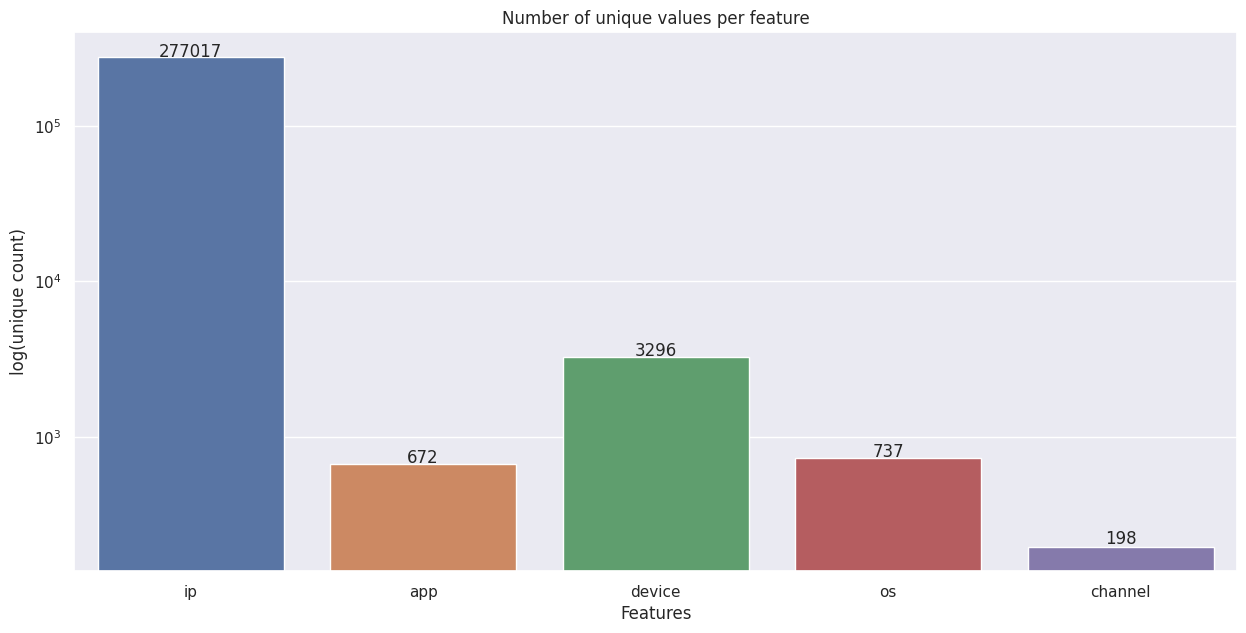

We can conclude that `ip` (Network Address) has the most unique values, followed by the `device` (device type id of user mobile phone), `app` (app id for marketing), `os` (os version id of user mobile phone), and `channel` (channel id of mobile ad publisher).

This information was useful for helping use better understand how many unique values we have for every feature in the dataset–what is commonly referred to as the cardinality of a feature. Understanding feature cardonality was essential because we intended to build a neural network and such information would ultimately influence how we encoded our categorical features and the complexity of our final NN.

### Conversion rates over Counts of 300 most popular IPs

* The mean of `is_attributed` can tell us the percentage of clicks that resulted in an app download for every `ip`. Even though the values in the `is_attributed` column are only 1 and 0, we can still calculate the mean of that column. When we take the mean of a binary variable like `is_attributed`, the resulting value represents the proportion of the observations that have a value of 1.

* By counting the number of clicks for each `ip`, we can get a sense of how many clicks each `ip` is responsible for. Additionally, having the count of clicks can give us a better sense of the overall volume of clicks for each ip.

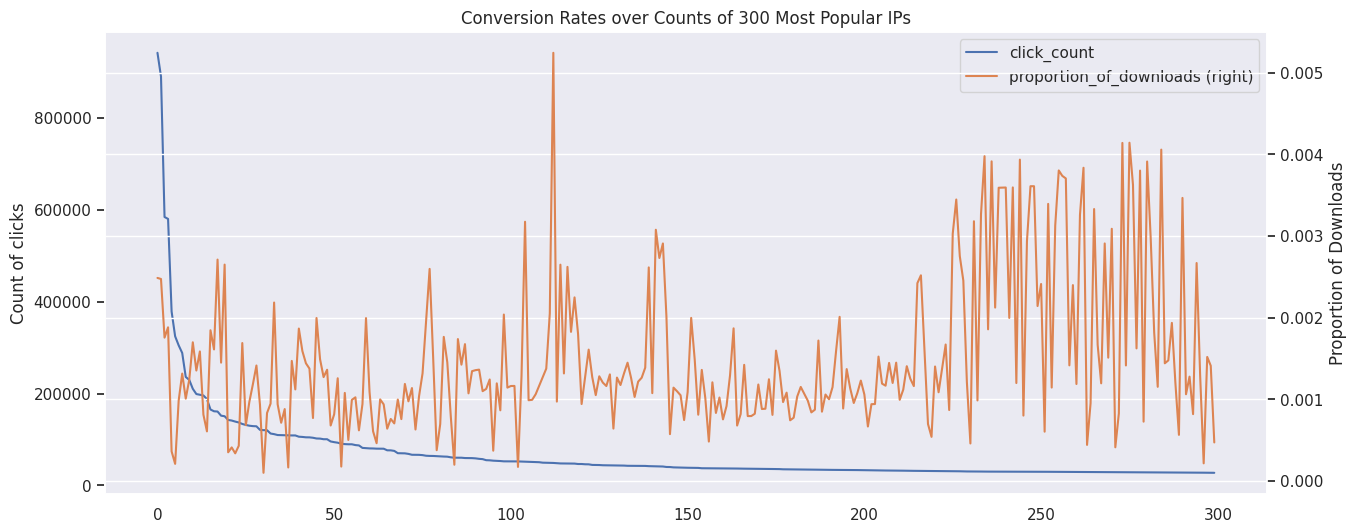

**Inference from the plot:**

* The plot shows the relationship between the count of clicks and the proportion of downloads (`is_attributed`=1) for the 300 most popular IPs in the dataset.

* We can see that for the IPs with the highest count of clicks, the proportion of downloads varies widely, from 0 to 0.4%. This suggests that the number of clicks alone is not a reliable indicator of the proportion of downloads.

### Conversions by os

Check 100 most popular os by click count:

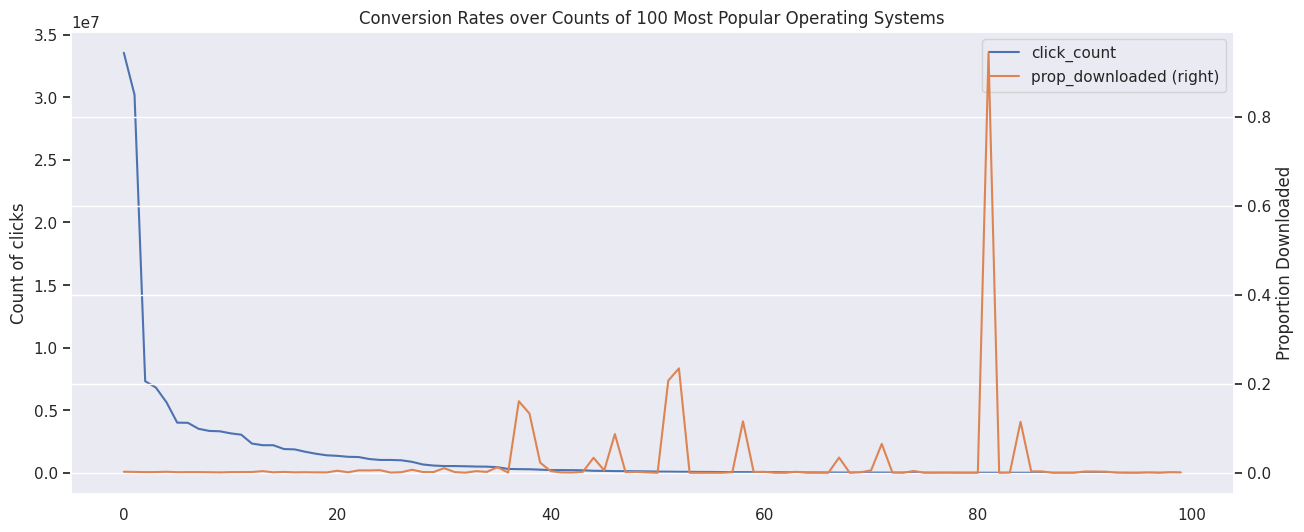

The plot shows the relationship between the count of clicks and the proportion of downloads (`is_attributed`=1) for the 100 most popular `os` in the dataset. Again, there does not seem to any a clear correlation between the click counts and the proportion of downloads for apps. Even though, we can see that a very small number of operating systems that contribute to large of clicks. This corresponds to the idea that there are only a few well know operating system in the market that most people use. 

### Exploring Time-Based Trends in the Data

We were give the click time of ads, and app downloads in the dataset. We extracted the hours from it and visualized it below. We wanted to check out how does the click counts change based on the hours during the span of the 4 days. Are they any spikes in clicks during certains hours of the day?

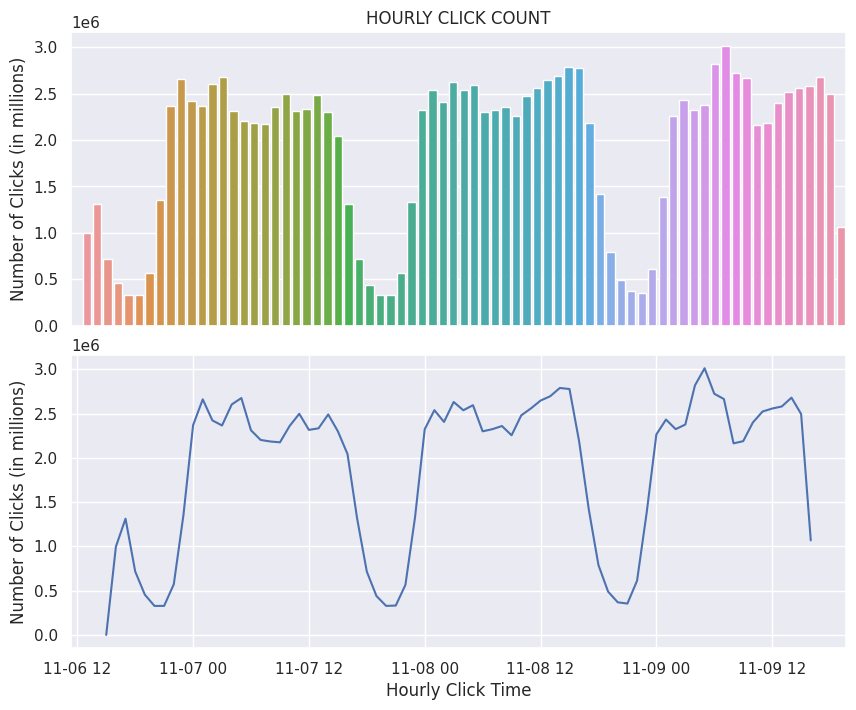

**Inference from the plots:**

* We can clearly visualize the trend in the plots - the number of clicks increases during the start of the day (right at midnight), and they remain consistent for the most part of the day, and then decreases as the day starts to end (around 2 pm). This is consistent trend for all the given dates.

* This means that we can utilize the hours of the click_time to gather information about the conversion ratios.

### Combining the Click counts and Click Conversion trends into one plot

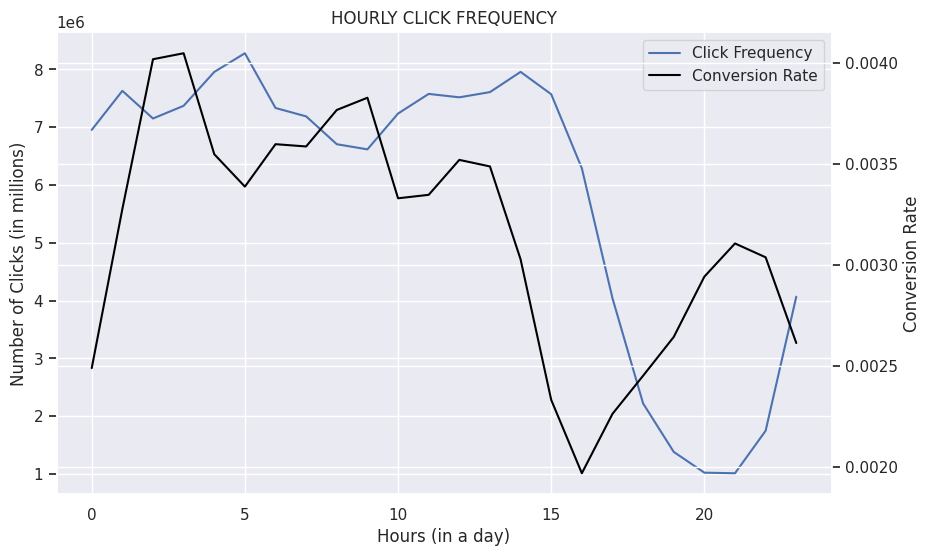

**Inference from the plot:**

The plot reveals that during the first half of the day, both the click counts and conversion rates are higher compared to the second half. Additionally, there is a declining trend in both variables that begins in the middle of the day and reaches its lowest point around the evening hours (between the 15th and 20th hour). However, we can observe an increase in both variables as the day is about to end.

## **Step 3:** Feature Engineering 

We performed feature engineering on the entire dataset, which was too computationally intensive to run on our local machines or Google Colab. Therefore, we utilized Google Cloud to access more powerful machines for this purpose.

In this notebook, we do not execute the code cells for feature engineering. Instead, we provide references to our supplementary notebooks, which contain all the details of our feature engineering process. However, we will discuss the features that we created during feature engineering, and how we came up with those features. 

**Here are the links to the supplement notebooks**: [Link1](https://github.com/heavenklair/mids_w207_repo_heaven/blob/main/Final_Project/EDA_v1.ipynb), [Link2](https://github.com/heavenklair/mids_w207_repo_heaven/blob/main/Final_Project/feature_eng_v1_part_1.ipynb), [Link3](https://github.com/heavenklair/mids_w207_repo_heaven/blob/main/Final_Project/feature_eng_v1_part2.ipynb), [Link4](https://github.com/heavenklair/mids_w207_repo_heaven/blob/main/Final_Project/feature_eng_v2_create_final_dataset.ipynb)

**Access the notebooks in the order they are provided to best make sense of them.**



In the initial stages of our machine learning project, we recognized the importance of feature engineering as a crucial step towards improving the performance of our predictive models. Given the nature of the dataset provided, which primarily consists of categorical variables, we sought to generate additional insights and better capture the underlying relationships between these variables. We devised three primary types of engineered features: 
1. count-based features, which represent the count of a variable grouped by other variables, 
2. basic statistical features, including the mean and variance of grouped variables, and 
3. time series features, specifically capturing the time elapsed between clicks for different grouped variables. 

Our multi-faceted approach enabled us to gain additional insights from the dataset and improve the model's performance in detecting fraudulent ad clicks. As we observed in the exploratory data analysis, there is a significant variability in the click and conversion rates across different variables. For instance, in the plot of conversion rates over counts of the 300 most popular IPs, we could not draw any meaningful conclusions from the plot. We observed similar variability in other plots as well, prompting us to create count-based variables and gain a better understanding of how different variables behave when grouped together.


Here are the **count-based variables** that we created: 

* `device_by_ip_day_hour` -  This variable will represent the count of unique `device` for each combination of `ip`, `day`, and `hour`. It essentially counts how many different `device` were clicked by a unique IP address in a given hour of a given day. This feature can be useful as it can help identify IPs that are repeatedly clicking on different device within a short period of time, which could indicate fraudulent activity.

* `device_by_ip_app` - This variable represents the count of unique devices for each combination of `ip` and `app`. It does this by grouping the dataframe by `ip` and `app`, counting the unique `device` values, and then merging the results back into the original dataframe. 

* `device_by_ip_app_os` - This variable represents the count of unique device for each combination of `ip`, `os` and `app`. It does this by grouping the dataframe by `ip`, `app` and `os`, and then counting the unique `device` values, and then merging the results back into the original dataframe. 

* `channel_by_ip_app` - It represents the count of unique `channel` for each combination of `ip` and `app`. It does so by grouping the dataframe by `ip` and `app`, counting the unique device values, and then merging the results back into the original dataframe.

* `channel_by_ip_day_hour` - It will represent the count of unique `channel` for each combination of `ip`, `day`, and `hour`. It essentially counts how many different `channel` were clicked by a unique IP address in a given `hour` of a given `day`.

* `channel_by_ip_app_os` - It represents the count of unique `device` for each combination of `ip`, `os` and `app`. It does this by grouping the dataframe by `ip`, `app` and `os`, and then counting the unique channel values.

In the time-series plots, we observed that there are certain hours when click and conversion counts increase significantly. To capture this variability and provide our model with a better understanding of when this occurs, we decided to create some statistics-based variables.

Here are the **statistic-based variables** that we created:

* `var_of_hour_given_ip_device_day` - It represents the variance of the hours in which a particular IP address makes clicks for a particular day and device combination. It tells us how the clicking behavior of a particular IP address varies across different hours for a given day and device.

* `var_of_hour_given_ip_os_app` - It represents the variance of the hours in which a particular IP address makes clicks for a particular `app` and `os` combination.

* `var_of_day_given_ip_app_device` - It captures the variability (variance) of the `day` feature within each unique combination of `ip`, `app`, and `device`. This feature could potentially be useful in detecting fraud, as it may indicate that certain combinations of `ip`, `app`, and `device` are more likely to be associated with fraudulent activity if the variance of the day feature is particularly high.

* `mean_of_hour_given_ip_app_channel` - It captures the average value of the `hour` feature within each unique combination of `ip`, `app`, and `channel`. This feature could potentially be useful in detecting fraud, as it may indicate that certain combinations of `ip`, `app`, and `channel` are more likely to be associated with fraudulent activity if the average value of the `hour` feature is particularly high or low.

The team discussed how human and bots could exhibit different behaviors when it comes to fraudulent clicks. The most important distinction highlighted was that humans tend to repeat clicking behavior only once. If a person likes the ad and downloads the app, they will not repeat this behavior. Conversely, if they do not like the app, they will not click on the ad again after clicking once. On the other hand, bots are programmed to click ads at fixed time intervals without downloading the app. To capture this distinction between human and bot behavior, we created the following time-series variables:


Here are the **time-series variables** that we created:

* `hourly_click_time` - The `hourly_click_time` column in the dataframe uses the round function to derive its values. It rounds the `click_time` column to the nearest hour. This means that all clicks that happened within the same hour will have the same value in the `hourly_click_time` column.

* `next_click_for_ip_app_device_os` - It captures the time duration (in seconds) from the current ad click to the next ad clicks involving the same IP address, app, device, and operating system.

* `next_click_for_unique_comb_ip_app_channel_os` - It captures the time duration (in seconds) from the current ad click to the next ad clicks involving the same IP address, app, channel, and operating system.

* `next_click_for_unique_comb_ip_device_channel_os` - It captures the time duration (in seconds) from the current ad click to the next ad clicks involving the same IP address, device, channel, and operating system.

The time-series variables are created with the hope in mind that they will enhance our model's ability to predict fraudulent ad clicks. By incorporating these features into our model, we can identify suspicious click patterns and irregularities that may suggest fraudulent activities. For instance, short time intervals between clicks from the same combination of factors could indicate automated or bot-driven actions. By detecting such anomalies, our model becomes more robust and accurate in identifying and preventing click fraud. 

**NOTE**: It is important to note that we did feature engineering on the entire dataset in order to preserve the randomness and capture the characteristics of the whole dataset. The links were provided in the beginning of the Feature Engineering section. Go through the links to read through the actual code for feature engineering on the entire dataset.

## **Step 4:** Baseline Model Review

While the kaggle competition used the probability a user will download as the metric for judgement, the training data consisted of binary classification as the target variable. A value of 1 was assigned to a click that led to a download while a value of 0 meant a click didn’t lead to a download. Due to the binary nature of the target feature, it was decided a logistic regression would be ideal for establishing a baseline. Furthermore, because of its historical performance with linear classifiers, we selected a logistic regression model from SKLearn that utilized stochastic gradient descent training. To ensure we created a strong baseline, we also tested a K Nearest Neighbor and Random Forest model to compare for accuray. Each model utilized a Onehot Encoded training set of four features: *app*, *device*, *os*, and *channel*.

<center>

| Model | Accuracy | AUC Accuracy | 
|:-: |:-: |:-: |
|Logistic Regression |91.1% |96.0%|
|KNN |90.8%|94.7%|
|Random Forest| 88.3% | 94.4%|

</center>

Ultimately, the logistic regression had the strongest scores and a test accuracy of 91.1% and an AUC accuracy of 96%. 

*Note: Further details and code related to each of our baseline models can be found [here](https://colab.research.google.com/drive/1EhCVK4EQCSxp0PDmFO5Hrh3AH36DxPNB#scrollTo=kQphqHuuoudm).*


## **Step 5:** Attempting to Outperform Baselines Models

Our initial suspension was that a highly complex NN would produce better results. However, implementing the model proved to be difficult. The biggest hurdle was one-hot encoding all the features. While keras has APIs for encoding, each feature had to be encoded individually, then concatenated together in the input layer of the model. However, once we were finally able to get the features encoded and model running, we saw a measly improvement of 1% from our superoir baseline model. Furthermore, the model would take hours to train, which made hypertuning the parameters extremely difficult. 

We the turned to the internet to research other models, and stumbled across projects that were producing some impressive results with LightGBM Models. This model worked extremely well with our larger data set and categorical features. In addition to it's superior performance in speed, LightGBM also produced our highest accuracy score, with a final test result of 94%.

### NN Model
In an effort to make this notebook more approachable, we've elected to note include the code needed for the NN. However, you access the NN's code and view the results [here](https://colab.research.google.com/drive/11U_dKue1Fc8xBlM2viilc_hRovtSme27?usp=share_link).

One additional hurdle we faced was the limitation of resourced needed to run the complex notebook. With the high cardonality of each feature, the enoded data set had nearly a million columns. This made trying to run the dataset with our limited resources nearly impossible–with each epoch taking nearly 5 hours to complete. As a result, we ran the NN with a less engineered dataset–one that only used two engineer features, day and hour of a click. 

The results of the NN were less than spectacular (shown below), so we continued our search for a better model.  


<center>

#### Training Results

| Loss | Accuracy | Val Loss | Val Accuracy |
|:-: |:-: |:-: |:-:|
|0.6164 |0.8589 |0.3067 |0.9087 
|0.3613 |0.8865 |0.2734 |0.9149 
|0.3472 |0.8871 |0.2633 |0.9157 
|0.3439 |0.8872 |0.2696 |0.9166 
|0.3429 |0.8884 |0.3135 |0.9157 

</center>

<br/>



<center>

#### Evaluation Results

| Loss | Accuracy |
|:-: |:-: |
|0.3127 |0.9135

</center>

### Basic LightGBM Model

After seeing the meager improvement of our NN, we ran a basic LightGBM model for comparison. Using the fast_ml library, we split our data into train, validate, test split using the fast_ml library. We ran the model with its default parameters, and it produced 94% accuracy on the validation set. Additionally, because the test and validation accuracy only varied by 1%, we concluded that the model was not overfitting.   

In [ ]:
#Based on the documentation found for LGBMClassifer parameters, 
#Setting data types as catagory for auto detection by LGBM.

#Training Set
for col in ['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'hour', 'day']:
    final_training_set[col] = final_training_set[col].astype('category')

#drop all unusded cols from the dataframe
final_training_set = final_training_set.drop(['click_time', 'attributed_time'], axis=1)


#Removing any NAN values to avoid error flag from LBGMClassifer when using cross validation
#we had an error raised but did not actually drop any rows when we checked our counts
#final_training_set.dropna(inplace=True)
#final_training_set.count()

#final_test_set.dropna(inplace=True)
#final_test_set.count()

In [ ]:
#Using fast_ml library to create a train, validation and test set
x_train_b, y_train_b, x_valid_b, y_valid_b, x_test_b, y_test_b = train_valid_test_split(final_training_set, 
                                                                            target = 'is_attributed', 
                                                                            train_size=0.8, 
                                                                            valid_size=0.1, 
                                                                            test_size=0.1)

print(x_train_b.shape), print(y_train_b.shape)
print(x_valid_b.shape), print(y_valid_b.shape)
print(x_test_b.shape), print(y_test_b.shape)

(593125, 20)
(593125,)
(74141, 20)
(74141,)
(74141, 20)
(74141,)


(None, None)

In [ ]:
#Building a very simple LGM Model
#default settings are as follows for LGBMClassifier
               #(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, 
               #n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, 
               #min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
               #subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, 
               #random_state=None, n_jobs=None, importance_type='split', **kwargs)
lgb_model = lgb.LGBMClassifier()
#Adjusted subsample_for_bin=200000 to 100000 with no change in model accuracy (valid 93.93% & train_test 93.90%)
#Adjusted learning_rate=0.1 to 0.01 with a decrease in model accuracy (valid 93.42% & train_test 93.28%)
#Adjusted learning_rate=0.1 to 0.05 with a decrease in model accuracy (valid 93.83% & train_test 93.78%)
#Adjusted boosting_rate='gbdt' to 'dart' with a decrease in model accuracy (valid 93.82% & train_test 93.75%)
#Adjusted min_child_samples=20 to 50 with a decrease in model accuracy (valid 93.94% & train_test 93.90%)

lgb_model.fit(x_train_b, y_train_b)
#default parameters for .fit: (X, y, sample_weight=None, init_score=None, eval_set=None, eval_names=None, 
                              #eval_sample_weight=None, eval_class_weight=None, eval_init_score=None, 
                              #eval_metric=None, feature_name='auto', categorical_feature='auto', 
                              #callbacks=None, init_model=None)
#No need to set catagorical features as the default is 'auto' 

LGBMClassifier()

In [ ]:
#Predicting the labes on x_valid &
#Checking the accuracy of our model based on our predictions: Valid Set
y_valid_pred_b = lgb_model.predict(x_valid_b)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_valid_b, y_valid_pred_b)))

#Predicting the labes on x_train &
#Checking the accuracy of our model based on our predictions: Training set
y_pred_train_b = lgb_model.predict(x_train_b)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train_b, y_pred_train_b)))

LightGBM Model accuracy score: 0.9409
Training-set accuracy score: 0.9462


Confusion Matrix
 [[37459  1433]
 [ 2950 32299]]


<Axes: >

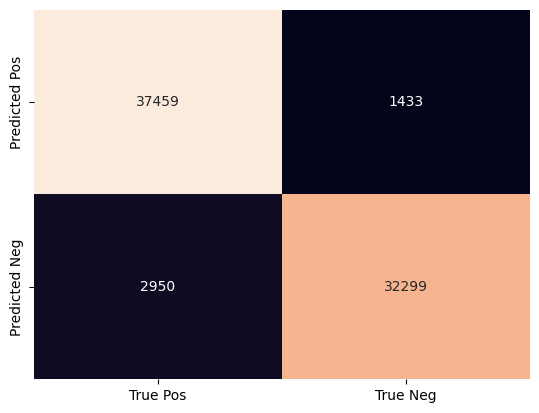

In [ ]:
#Confusion Matrix of the validation set
conf_matrix = confusion_matrix(y_valid_b, y_valid_pred_b)
print('Confusion Matrix\n', conf_matrix)

#Heatmap
conf_matrix_hm = pd.DataFrame(data=conf_matrix, columns=['True Pos', 'True Neg'], index=['Predicted Pos', 'Predicted Neg'])
sns.heatmap(conf_matrix_hm, annot=True, fmt='d', cbar=False)

In [ ]:
print(classification_report(y_valid_b, y_valid_pred_b))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94     38892
           1       0.96      0.92      0.94     35249

    accuracy                           0.94     74141
   macro avg       0.94      0.94      0.94     74141
weighted avg       0.94      0.94      0.94     74141



In [ ]:
#predicting the labes on x_test created from the training set
y_test_pred_b = lgb_model.predict(x_test_b)

#Checking the accuracy of our model based on our predictions: test Set
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test_b, y_test_pred_b)))

LightGBM Model accuracy score: 0.9408


### Using Cross-Validation to Varify Performance

After seeing some initial success with LightGBM, we wanted to verify the models performance before using it on our final test data. We opted to use SK-Learn's K-Fold Cross-Validation to run 5 iterations of training and prediction on the model using different sections of the training data for validation. 

The scores of the cross-validation were promising, producing a mean validation score of 93.9% and a mean area under the score curve of 98.3%. The mean AUC is important because that's how the final score of the Kaggle competition is judged. 

These scores lead us to select the LightGBM as our final model. Thus, we moved forward with testing hyperparameters. 

In [ ]:
#Selecting features and setting label
features = final_training_set[['ip', 'app', 'device', 'os', 'channel', 'hour', 'day', 
                'device_by_ip_day_hour', 'device_by_ip_app', 'device_by_ip_app_os', 
                'mean_of_hour_given_ip_app_device', 'next_click_for_ip_app_device_os', 
                'next_click_for_unique_comb_ip_app_channel_os', 'next_click_for_unique_comb_ip_device_channel_os']]
labels = final_training_set['is_attributed']
print(features.shape)
print(labels.shape)

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.01, random_state=42)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(741407, 14)
(741407,)
(733992, 14) (733992,)
(7415, 14) (7415,)


In [ ]:
## Function fitting model using CV
def cv_model(model, x_train, y_train):
    """
    Function for fitting a model using cross-validation

    Input parameters:
    model: model to train
    x_test: train features
    y_test: train labels

    Output variables:
    model: trained model
    accuracies: list of accuracies for each iteration
    oof_auc = average auc score
    """

    # tracking variables
    fold = 0 
    auc_accuracies = []
    val_accuracies = []

    # creating CV generator
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in kf.split(x_train, y_train):
        # creating train/val set
        x_tr = x_train.iloc[train_idx]
        y_tr = y_train.iloc[train_idx]

        x_val = x_train.iloc[val_idx]
        y_val = y_train.iloc[val_idx]

        # Fit Model
        model.fit(x_tr, y_tr)
        pred = model.predict(x_val)
        pred_prob = model.predict_proba(x_val)[:,1]
        val_acc_score = accuracy_score(y_val, pred)
        auc_score = roc_auc_score(y_val, pred_prob)
        print(f"======= Fold {fold} ========")
        print(
            f"Our accuracy on the validation set is {val_acc_score:0.4f} and AUC is {auc_score:0.4f}"
        )
        fold += 1
        auc_accuracies.append(auc_score)
        val_accuracies.append(val_acc_score)

    oof_auc = np.mean(auc_accuracies)
    mean_val_acc = np.mean(val_accuracies)
    print(f"======= Mean AUC ========\n{oof_auc:.4f}")
    print(f"======= Mean Val Acc ========\n{mean_val_acc:.4f}")
    return auc_accuracies, val_accuracies

In [ ]:
lgb_model = lgb.LGBMClassifier()
lgb_val_acc, lgb_oof_auc = cv_model(lgb_model, x_train, y_train)

======= Fold 0 ========
Our accuracy on the validation set is 0.9401 and AUC is 0.9832
======= Fold 1 ========
Our accuracy on the validation set is 0.9400 and AUC is 0.9834
======= Fold 2 ========
Our accuracy on the validation set is 0.9402 and AUC is 0.9832
======= Fold 3 ========
Our accuracy on the validation set is 0.9404 and AUC is 0.9832
======= Fold 4 ========
Our accuracy on the validation set is 0.9400 and AUC is 0.9834
======= Mean AUC ========
0.9833
======= Mean Val Acc ========
0.9401


## **Step 6:** Final Model - LightGBM Model

The LightGBM model performed better than we anticipated with an accuracy score of 94% on our validation set. This model is unique in that it builds trees horizontally as opposed to other algorithms that grow trees vertically. Upon further reading of the documentation we have found the biggest advantages to using this approach were as follows:

*   Can handle large data sets in less time than many other models
*   LightGBM models can use categorical features as an input directly without the need for one-hot encoding. It is about 8 times faster than one-hot encoding 
*   Less Memory Usage
*   Because of the complexity of trees created by leaf-wise split LightGBM Models have a better accuracy as compared to other boosted models 

Disadvantages of using a LightGBM model are as follows: 
*   Can easily overfit
*   Not ideal for small datasets

</br>

#### Optimzation Attempts
In an effort to squeeze out slightly better performance from the model, we attempted hypertuning the parameters of the model on version 3 of our feature engineered training set. These included experimenting with various learning rates, trying tree depth and tree leaves, as well as the number of samples for constructing bins. Despite these effort, hypertuning parameters failed to increase performance–and in many cases, it actually decreased our accuracy. Utlimately, the default parameters used with the LightGBM model produced the best results. 

| HYPERPARAMETER | CHANGED | VALID ACCURACY | TEST ACCURACY |
|:-: |:-: |:-: | :-:|
| Default | Default| 93.93%| 93.90% |
|subsample_bar=200000| 100000| 93.93% |93.90% |
|learning_rate=0.1 | 0.01 | 93.42%| 93.28%|
|learning_rate=0.1 | 0.05 | 93.83% | 93.78%| 
|boosting_rate='gbdt'| 'dart' | 93.82% | 93.75%| 
| min_child_samples=20 | 50 | 93.94% | 93.90%|
|num_leaves=31| 62 | 93.93% | 94.04%|  

We did conduct some additional feature engineering and were able to increase our default performance by a fraction of a percentage to over 94% consistently. The outputs you see in this notebook are using the training set we created with that additional feature engineering. You can find a complete notebook of our LGBM Model work [here](https://colab.research.google.com/drive/1JfcB3lPq1bUni3L_LswFWc-91daD8djx?usp=sharing).

######*Sources:* 

*   https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
*   https://lightgbm.readthedocs.io/en/latest/Python-Intro.html
*   https://www.kaggle.com/general/264327
*   https://www.analyticsvidhya.com/blog/2021/08/complete-guide-on-how-to-use-lightgbm-in-python/

In [ ]:
## Function for evaluating model
def eval_model(model, x_test, y_test):
    """
    Function for evaluating model's performance.
    
    Input parameters:
    model: model to evaluate
    x_test: test features
    y_test: test labels

    Output variables:
    acc_score: accuracy score
    auc_score: area under the curve score
    test_pred: test predictions
    test_pred_prob: test prediction probabilities
    """

    ## Evaluating model on test data
    test_pred = model.predict(x_test)
    test_pred_prob = model.predict_proba(x_test)[:,1]
    acc_score = accuracy_score(y_test, test_pred)
    auc_score = roc_auc_score(y_test, test_pred_prob)
    print(f"Accuracy Score: {acc_score:.4f}\nAUC Score: {auc_score:.4f}")

    return acc_score, auc_score, test_pred, test_pred_prob

In [ ]:
lgb_trained = lgb_model.fit(x_train, y_train)
lgb_acc_score, lgb_auc_score, lgb_test_pred, lgb_test_pred_prob = eval_model(lgb_trained, x_test, y_test)

Accuracy Score: 0.9423
AUC Score: 0.9851


## **Step 7:** Conclusion

#### Challenges: 
- As previously mentioned, one of our biggest struggles was working with such a large dataset on limited resources. While downsampling our data set was a huge help in making our dataset more manageble, we still experience problems. Mainly, we still had nearly a million records, which–when coupled with the fact each feature had a high degree of cardinality–made running advance models like NN nearly impossible with our limited resources. Furthermore, we also struggled with learning how to encode our features depending upon the libraries we were using to build models, i.e. Keras or SK-Learn. 

#### Biggest Take Aways: 
- Initially, we were focusing a lot of effort on using feature engineering to improve our results our initial models. Unforunately, we didn't see any improvements with the the engineered features. This was a big lesson in the value of finding the right model for the job. 

#### What would we do differently: 
- Based on the biggest takeway from the project, we would have spent more time searching for better models if given the opporuntity to do it different. While it was important to research how we could use featuring engineering to potentially uncover trends in the data, without the right model that effort may be meaningless. 
